In [573]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [575]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Lasso,lasso_path

from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, KFold

In [577]:
# for pca to fix colinearity 
from sklearn.decomposition import PCA

# checking olinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [579]:
#reading file

df= pd.read_csv('/Users/morgan/Desktop/SEIS 763 ML/ML_job_postings_finale_ready_v2.csv',header=0)
df.head()

,job_id,title,work_type,description,location,zip_code,min_salary,max_salary,normalized_salary,views,...,sector,city,state,name,latitude,longitude,gdp,income,region,moving_score
0,1014822088,Marketing Specialist,FULL_TIME,About TrackerTracker is a leading global cloud...,United States,NaN,70000.0,80000.0,75000.0,7.0,...,Information Technology,United States,US,Remote,NaN,NaN,483162.0,416325.0,Plains,50.000000
1,3189117072,Client Service Associate / Practice Manager,FULL_TIME,Company OverviewSignature Estate and Investmen...,"Redondo Beach, CA",90277.0,70000.0,100000.0,85000.0,6.0,...,Energy,Redondo Beach,CA,California,36.778261,-119.417932,3870379.0,3166135.0,Far West,4.214518
2,3260455681,Operations Specialist,FULL_TIME,Weyerhaeuser is searching for a Operations Spe...,"Castle Rock, WA",98611.0,72742.0,109113.0,90927.5,18.0,...,Materials,Castle Rock,WA,Washington,47.751074,-120.740139,807865.0,632296.0,Far West,4.703287
3,3277232283,HR & Administrative Assistant,FULL_TIME,HR & Administrative CoordinatorWork is Remote ...,United States,NaN,55000.0,72000.0,63500.0,59.0,...,Energy,United States,US,Remote,NaN,NaN,483162.0,416325.0,Plains,50.000000
4,3297645846,Contract Administrator,FULL_TIME,Contract AdministratorSummary of PositionThe C...,"Broomfield, CO",80020.0,74400.0,90000.0,82200.0,6.0,...,Materials,Broomfield,CO,Colorado,39.550051,-105.782067,529627.0,470606.0,Rocky Mountain,8.368978


In [581]:
df.columns

Index(['job_id', 'title', 'work_type', 'description', 'location', 'zip_code',
       'min_salary', 'max_salary', 'normalized_salary', 'views',
       'original_listed_time', 'expiry', 'day_posting', 'is_data_related',
       'formatted_experience_level', 'degree_level', 'job_classification',
       'soft_skills', 'programming_languages_score',
       'analysis_statistics_score', 'machine_learning_score',
       'data_visualization_score', 'cloud_platform_score', 'database_score',
       'big_data_tools_score', 'big_data_score', 'business_engineering_score',
       'company_id', 'company_name', 'company desc', 'company_size', 'country',
       'headquarter state', 'headquarter city', 'headquarter addr',
       'headquarter zipcode', 'industry', 'speciality', 'employee_count',
       'follower_count', 'sector', 'city', 'state', 'name', 'latitude',
       'longitude', 'gdp', 'income', 'region', 'moving_score'],
      dtype='object')

## LINEAR REGRESSION PART 1: Overview of the numerical variables

In [584]:
#regression model using mostly numerical variables

reg_df=df[['normalized_salary','programming_languages_score',
           'analysis_statistics_score', 'machine_learning_score',
           'data_visualization_score', 'cloud_platform_score', 'database_score',
           'big_data_score','views','company_size','employee_count','follower_count', 'gdp', 'income','moving_score',
           'degree_level','job_classification','day_posting']]

In [586]:
# 1st Standardization
# Select numerical columns to be standardized
numerical_cols = [ 'programming_languages_score', 'day_posting',
                   'analysis_statistics_score', 'machine_learning_score',
                   'data_visualization_score', 'cloud_platform_score', 'database_score',
                   'big_data_score', 'views', 'company_size', 'employee_count', 'follower_count', 'gdp', 'income', 'moving_score']

# Standardize numerical columns
scaled_data = preprocessing.scale(df[numerical_cols])
scaled_df = pd.DataFrame(scaled_data, columns=numerical_cols, index=df.index)

# Combine standardized numerical columns with categorical columns
reg_df = pd.concat([scaled_df, df[['degree_level', 'job_classification','normalized_salary']]], axis=1)

In [588]:
def fill_na_with_mean(df, columns):
  """
  Fills missing values in specified columns with their respective column means.

  Args:
    df: The DataFrame.
    columns: A list of column names to fill missing values.

  Returns:
    The DataFrame with missing values filled.
  """

  for col in columns:
    mean_value = df[col].mean()
    df[col].fillna(mean_value, inplace=True)

  return df

In [590]:
def apply_pca(df, columns, new_column_name):
    """
    Applies PCA to the specified columns and adds the first principal component to the DataFrame.

    Args:
        df: The DataFrame.
        columns: A list of column names to apply PCA to.
        new_column_name: The name of the new column to store the first principal component.

    Returns:
        The DataFrame with the added principal component.
    """

    pca = PCA(n_components=1)
    pca_result = pca.fit_transform(df[columns])
    df[new_column_name] = pca_result.flatten()
    df = df.drop(columns, axis=1)

    return df

In [592]:
def plot_histograms(df, columns, nrows=3, ncols=3, figsize=(15, 10)):
    """
    Plots histograms for the specified columns in a DataFrame.

    Args:
        df: The DataFrame containing the data.
        columns: A list of column names to plot.
        nrows: Number of rows in the subplot grid.
        ncols: Number of columns in the subplot grid.
        figsize: Figure size in inches.
    """

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(df[col], ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [594]:
def remove_outliers_zscore_inplace(df, columns, threshold=3):
    """
    Removes outliers from a DataFrame based on z-scores, modifying the DataFrame in-place.

    Args:
        df: The DataFrame to process.
        columns: A list of column names to consider for outlier detection.
        threshold: The z-score threshold for identifying outliers.
    """

    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        df.drop(df[z_scores > threshold].index, inplace=True)

In [596]:
# Melt the DataFrame to a long format for easier plotting
# Select the columns of interest
def boxplot_check(df,columns):
    """
    Plot box-plot to identify outliers.

    Args:
        df: The DataFrame to process.
        columns: A list of column names to consider for ploting and outlier detection.

    Returns:
        boxplots
    """
    df_melted = df[columns].melt()
    
    # Create a boxplot
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='variable', y='value', data=df_melted)
    plt.title('Boxplot of Numerical Features')
    plt.xlabel('Feature')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.show()

In [598]:
def plot_scatter_plots(df, target_col, predictors):
    """
    Plots scatter plots of the target variable against each predictor variable.

    Args:
        df: The DataFrame containing the data.
        target_col: The name of the target column.
        predictors: A list of predictor column names.
    """

    num_plots = len(predictors)
    ncols = 3  # Number of columns in the subplot grid
    nrows = (num_plots - 1) // ncols + 1

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    axes = axes.flatten()

    for i, predictor in enumerate(predictors):
        sns.scatterplot(x=target_col, y=predictor, data=df, ax=axes[i])
        axes[i].set_title(f'{target_col} vs {predictor}')

    plt.tight_layout()
    plt.show()

In [600]:
def check_collinearity(df):
    """
    Checks for collinearity in a DataFrame.

    Args:
        df: The DataFrame to check.

    Returns:
        None
    """

    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Visualize the correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # Calculate VIF for each variable
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

    print(vif_data)


In [602]:
fill_na_with_mean(reg_df, numerical_cols)

,programming_languages_score,day_posting,analysis_statistics_score,machine_learning_score,data_visualization_score,cloud_platform_score,database_score,big_data_score,views,company_size,employee_count,follower_count,gdp,income,moving_score,degree_level,job_classification,normalized_salary
0,-0.452481,-0.259610,-1.076348,-0.159101,-0.303886,0.944862,-0.558888,-0.179187,-0.215448,-1.633884e+00,-0.377830,-0.317965,-0.767601,-0.762980,1.906802,bachelor,Engineering,75000.0
1,-0.452481,-0.259610,-1.076348,-0.159101,-0.303886,0.944862,0.554892,-0.179187,-0.228575,-1.633884e+00,-0.377079,-0.318035,1.825393,1.855966,-0.665311,bachelor,Engineering,85000.0
2,-0.452481,4.231212,-0.146959,-0.159101,-0.303886,0.944862,-0.558888,-0.179187,-0.071046,8.783103e-01,-0.318020,-0.302601,-0.519033,-0.557287,-0.637853,bachelor,Engineering,90927.5
3,-0.452481,-0.259610,-0.146959,-0.159101,-0.303886,0.944862,0.554892,-0.179187,0.467181,-2.540989e-16,-0.378393,-0.318667,-0.767601,-0.762980,1.906802,bachelor,Other,63500.0
4,-0.452481,4.231212,-0.146959,-0.159101,1.528821,-0.643614,-0.558888,-0.179187,-0.228575,-1.265676e-01,-0.376668,-0.318756,-0.732031,-0.711282,-0.431924,bachelor,Engineering,82200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,-0.452481,-0.259610,-1.076348,-0.159101,-0.303886,-0.643614,-0.558888,-0.179187,-0.254830,8.783103e-01,-0.192799,-0.150011,-0.296663,-0.295991,0.070069,bachelor,Engineering,190050.0
3898,1.765587,-0.259610,0.782430,-0.159101,-0.303886,0.944862,-0.558888,-0.179187,-0.254830,8.783103e-01,-0.192799,-0.150011,-0.500689,-0.530475,-0.568299,bachelor,Engineering,112850.0
3899,2.874621,-0.259610,-1.076348,-0.159101,-0.303886,-0.643614,-0.558888,-0.179187,-0.241703,-1.131445e+00,-0.376731,-0.318258,1.825393,1.855966,-0.665311,bachelor,Engineering,159200.0
3900,0.656553,-0.259610,1.711819,-0.159101,3.361528,-0.643614,1.668673,-0.179187,-0.267958,-1.265676e-01,-0.370699,-0.304412,1.825393,1.855966,-0.665311,bachelor,Engineering,137280.0


In [604]:
#reg_df.isnull().sum()

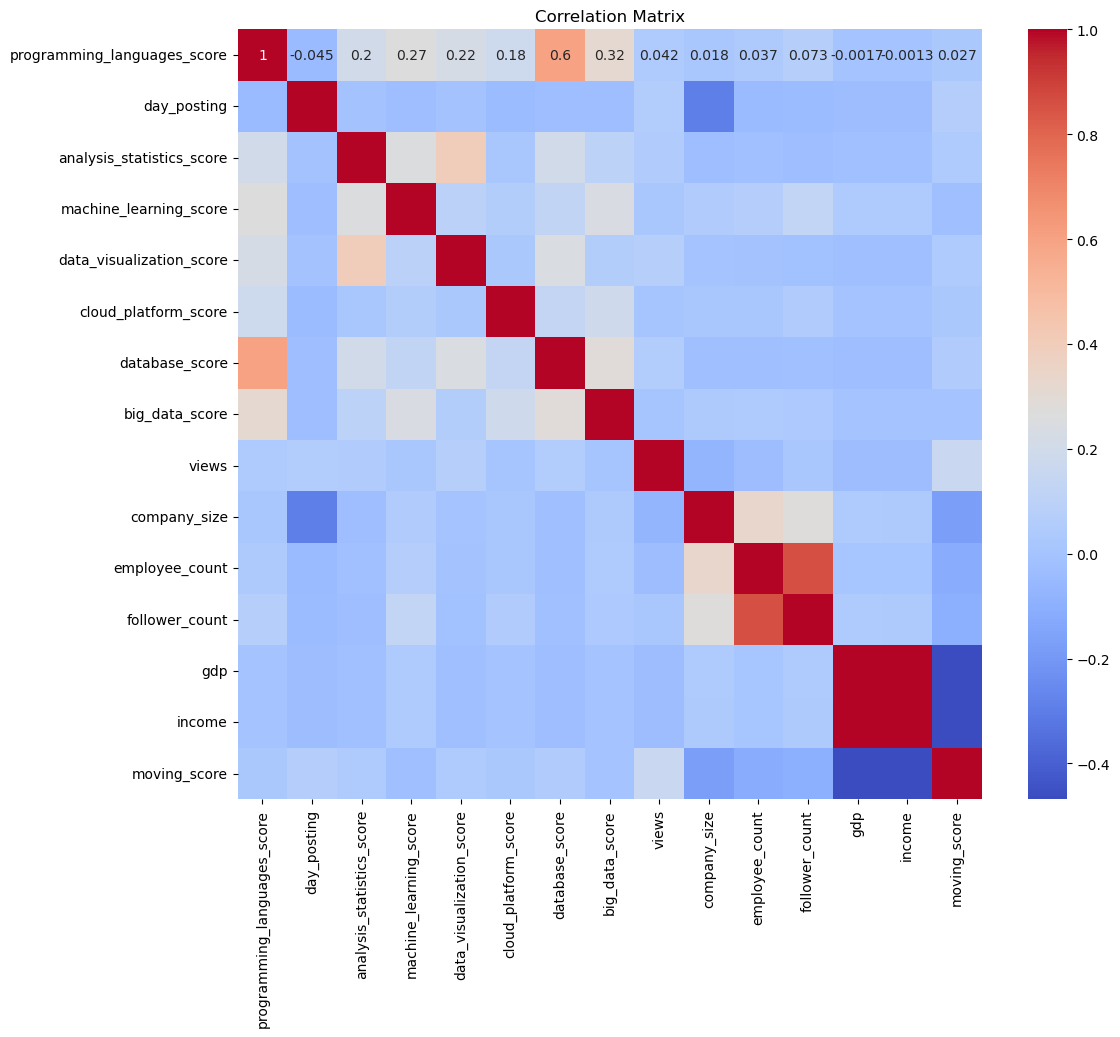

                        feature         VIF
0   programming_languages_score    1.750084
1                   day_posting    1.105140
2     analysis_statistics_score    1.279180
3        machine_learning_score    1.204147
4      data_visualization_score    1.240042
5          cloud_platform_score    1.061992
6                database_score    1.660719
7                big_data_score    1.194097
8                         views    1.049398
9                  company_size    1.258875
10               employee_count    4.058511
11               follower_count    3.987939
12                          gdp  209.876602
13                       income  209.533299
14                 moving_score    1.360429


In [606]:
check_collinearity(reg_df[numerical_cols])

In [608]:
apply_pca(reg_df, ['income','gdp'], 'economic_score')

,programming_languages_score,day_posting,analysis_statistics_score,machine_learning_score,data_visualization_score,cloud_platform_score,database_score,big_data_score,views,company_size,employee_count,follower_count,moving_score,degree_level,job_classification,normalized_salary,economic_score
0,-0.452481,-0.259610,-1.076348,-0.159101,-0.303886,0.944862,-0.558888,-0.179187,-0.215448,-1.633884e+00,-0.377830,-0.317965,1.906802,bachelor,Engineering,75000.0,-1.082284
1,-0.452481,-0.259610,-1.076348,-0.159101,-0.303886,0.944862,0.554892,-0.179187,-0.228575,-1.633884e+00,-0.377079,-0.318035,-0.665311,bachelor,Engineering,85000.0,2.603114
2,-0.452481,4.231212,-0.146959,-0.159101,-0.303886,0.944862,-0.558888,-0.179187,-0.071046,8.783103e-01,-0.318020,-0.302601,-0.637853,bachelor,Engineering,90927.5,-0.761073
3,-0.452481,-0.259610,-0.146959,-0.159101,-0.303886,0.944862,0.554892,-0.179187,0.467181,-2.540989e-16,-0.378393,-0.318667,1.906802,bachelor,Other,63500.0,-1.082284
4,-0.452481,4.231212,-0.146959,-0.159101,1.528821,-0.643614,-0.558888,-0.179187,-0.228575,-1.265676e-01,-0.376668,-0.318756,-0.431924,bachelor,Engineering,82200.0,-1.020576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,-0.452481,-0.259610,-1.076348,-0.159101,-0.303886,-0.643614,-0.558888,-0.179187,-0.254830,8.783103e-01,-0.192799,-0.150011,0.070069,bachelor,Engineering,190050.0,-0.419070
3898,1.765587,-0.259610,0.782430,-0.159101,-0.303886,0.944862,-0.558888,-0.179187,-0.254830,8.783103e-01,-0.192799,-0.150011,-0.568299,bachelor,Engineering,112850.0,-0.729143
3899,2.874621,-0.259610,-1.076348,-0.159101,-0.303886,-0.643614,-0.558888,-0.179187,-0.241703,-1.131445e+00,-0.376731,-0.318258,-0.665311,bachelor,Engineering,159200.0,2.603114
3900,0.656553,-0.259610,1.711819,-0.159101,3.361528,-0.643614,1.668673,-0.179187,-0.267958,-1.265676e-01,-0.370699,-0.304412,-0.665311,bachelor,Engineering,137280.0,2.603114


In [610]:
apply_pca(reg_df, ['employee_count','follower_count'], 'company_score')

,programming_languages_score,day_posting,analysis_statistics_score,machine_learning_score,data_visualization_score,cloud_platform_score,database_score,big_data_score,views,company_size,gdp,income,moving_score,degree_level,job_classification,normalized_salary,economic_score,company_score
0,-0.452481,-0.259610,-1.076348,-0.159101,-0.303886,0.944862,-0.558888,-0.179187,-0.215448,-1.633884e+00,-0.767601,-0.762980,1.906802,bachelor,Engineering,75000.0,-1.082284,-0.492001
1,-0.452481,-0.259610,-1.076348,-0.159101,-0.303886,0.944862,0.554892,-0.179187,-0.228575,-1.633884e+00,1.825393,1.855966,-0.665311,bachelor,Engineering,85000.0,2.603114,-0.491520
2,-0.452481,4.231212,-0.146959,-0.159101,-0.303886,0.944862,-0.558888,-0.179187,-0.071046,8.783103e-01,-0.519033,-0.557287,-0.637853,bachelor,Engineering,90927.5,-0.761073,-0.438846
3,-0.452481,-0.259610,-0.146959,-0.159101,-0.303886,0.944862,0.554892,-0.179187,0.467181,-2.540989e-16,-0.767601,-0.762980,1.906802,bachelor,Other,63500.0,-1.082284,-0.492896
4,-0.452481,4.231212,-0.146959,-0.159101,1.528821,-0.643614,-0.558888,-0.179187,-0.228575,-1.265676e-01,-0.732031,-0.711282,-0.431924,bachelor,Engineering,82200.0,-1.020576,-0.491739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,-0.452481,-0.259610,-1.076348,-0.159101,-0.303886,-0.643614,-0.558888,-0.179187,-0.254830,8.783103e-01,-0.296663,-0.295991,0.070069,bachelor,Engineering,190050.0,-0.419070,-0.242403
3898,1.765587,-0.259610,0.782430,-0.159101,-0.303886,0.944862,-0.558888,-0.179187,-0.254830,8.783103e-01,-0.500689,-0.530475,-0.568299,bachelor,Engineering,112850.0,-0.729143,-0.242403
3899,2.874621,-0.259610,-1.076348,-0.159101,-0.303886,-0.643614,-0.558888,-0.179187,-0.241703,-1.131445e+00,1.825393,1.855966,-0.665311,bachelor,Engineering,159200.0,2.603114,-0.491431
3900,0.656553,-0.259610,1.711819,-0.159101,3.361528,-0.643614,1.668673,-0.179187,-0.267958,-1.265676e-01,1.825393,1.855966,-0.665311,bachelor,Engineering,137280.0,2.603114,-0.477375


In [612]:
reg_df.columns

Index(['programming_languages_score', 'day_posting',
       'analysis_statistics_score', 'machine_learning_score',
       'data_visualization_score', 'cloud_platform_score', 'database_score',
       'big_data_score', 'views', 'company_size', 'employee_count',
       'follower_count', 'gdp', 'income', 'moving_score', 'degree_level',
       'job_classification', 'normalized_salary', 'economic_score',
       'company_score'],
      dtype='object')

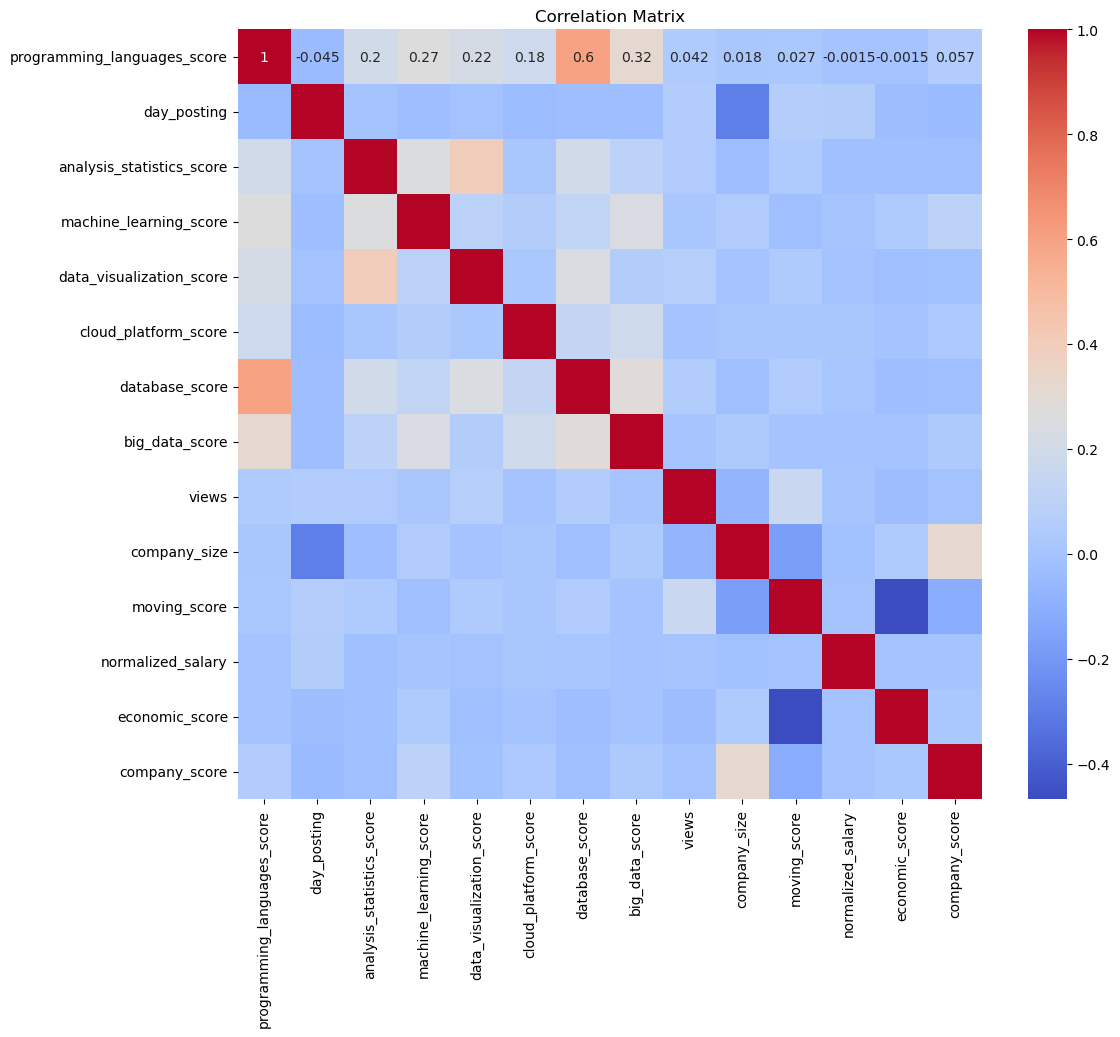

                        feature       VIF
0   programming_languages_score  1.743923
1                   day_posting  1.109263
2     analysis_statistics_score  1.275281
3        machine_learning_score  1.187184
4      data_visualization_score  1.239666
5          cloud_platform_score  1.059068
6                database_score  1.659714
7                big_data_score  1.189276
8                         views  1.038287
9                  company_size  1.243658
10                 moving_score  1.359852
11            normalized_salary  1.005397
12               economic_score  1.289851
13                company_score  1.132984


In [618]:
#reg_df=reg_df.drop(['income','gdp','employee_count','follower_count'],axis=1)

new_num_columns = list(reg_df.columns[:-5]) + list(reg_df.columns[-3:])
check_collinearity(reg_df[new_num_columns])

In [620]:
remove_outliers_zscore_inplace(reg_df, new_num_columns , threshold=3)

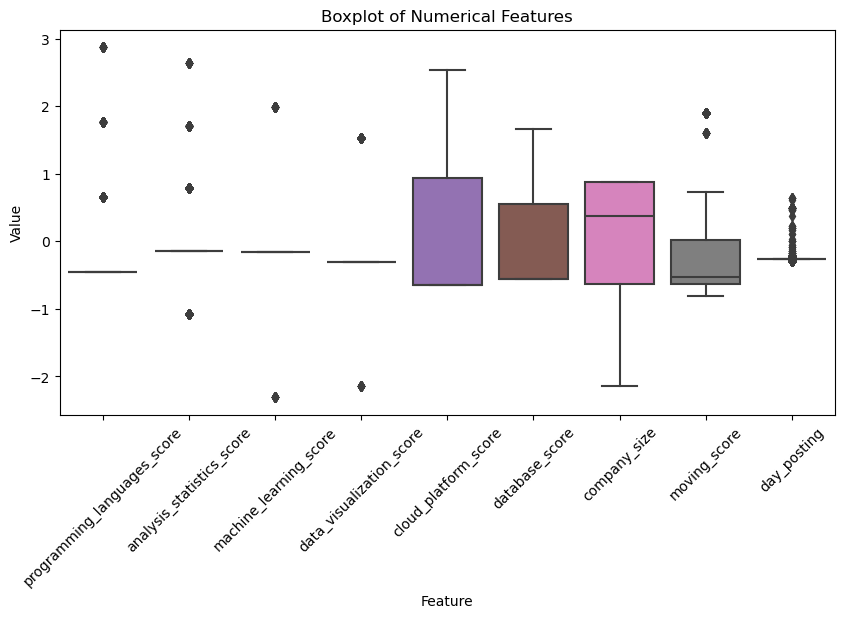

In [622]:
boxplot_check(reg_df,['programming_languages_score', 
                   'analysis_statistics_score', 'machine_learning_score',
                   'data_visualization_score', 'cloud_platform_score', 'database_score',
                   'company_size','moving_score','day_posting']) 

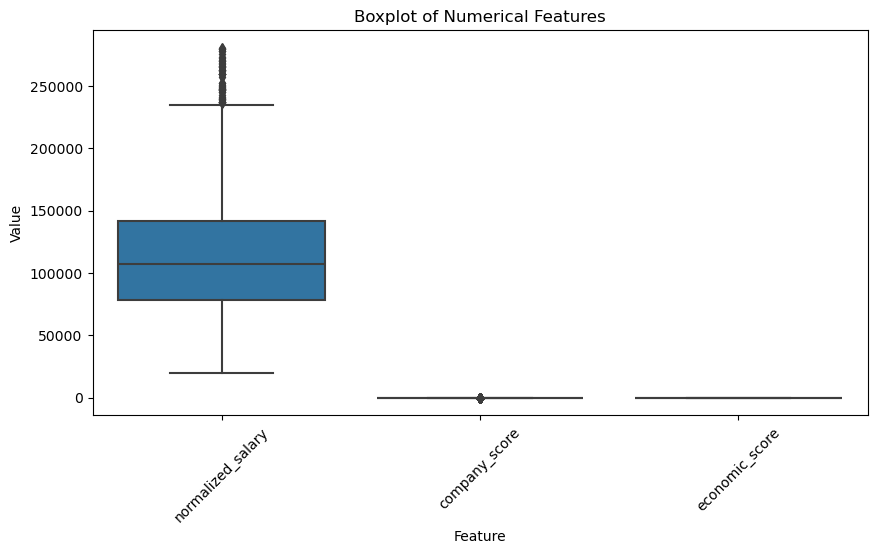

In [624]:
boxplot_check(reg_df,['normalized_salary','company_score','economic_score'
           ])

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed

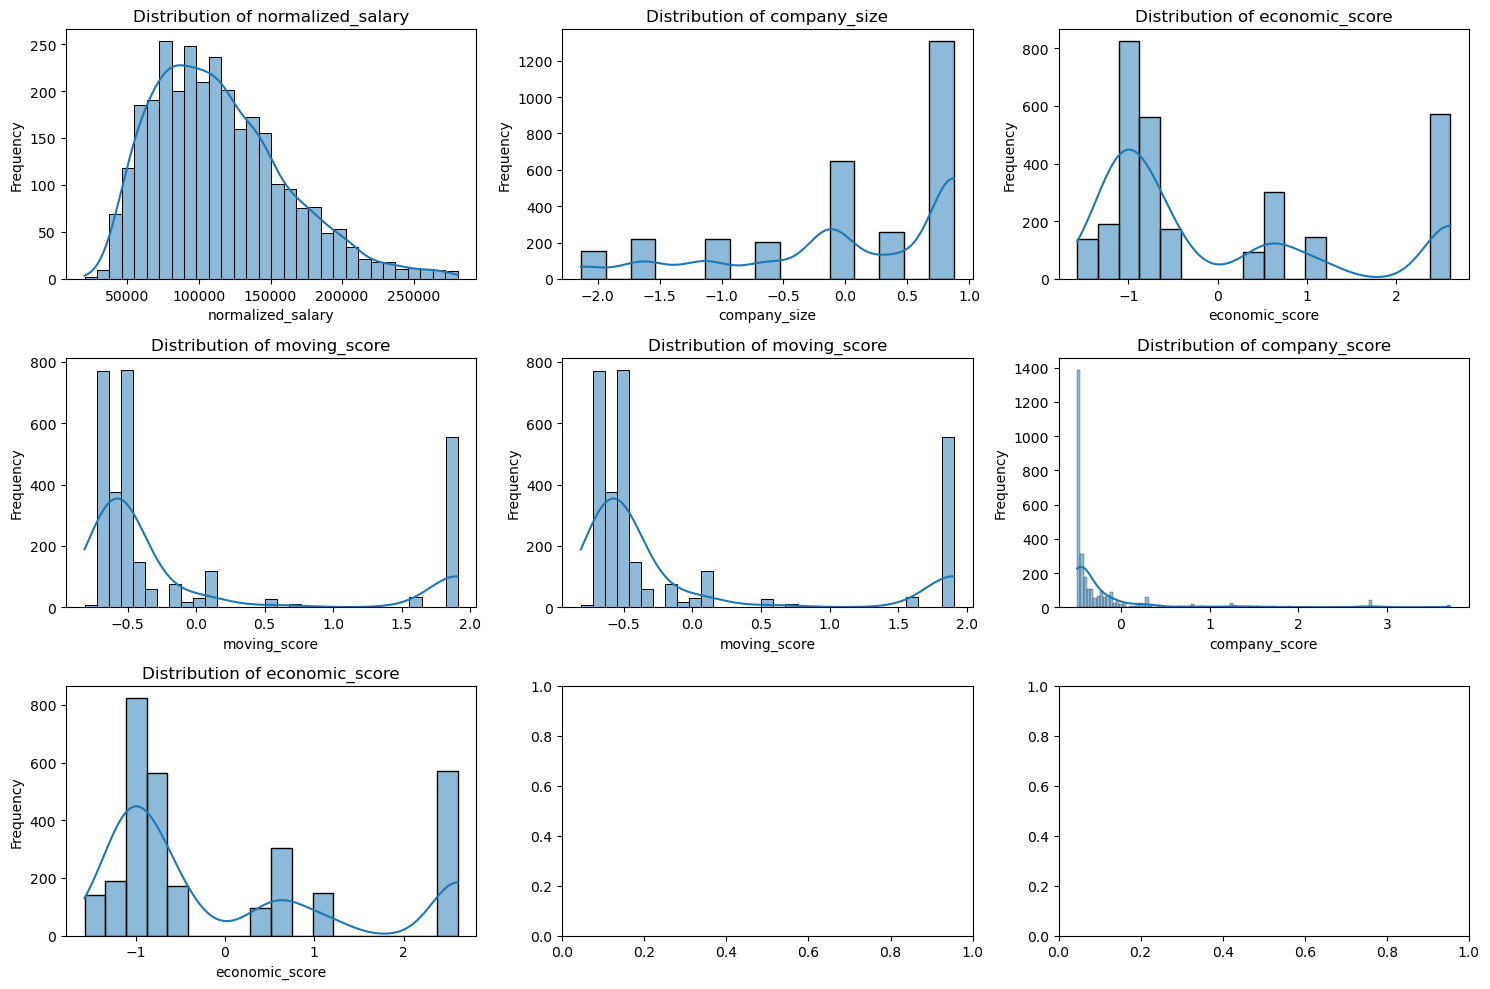

In [626]:
columns_to_plot = ['normalized_salary','company_size', 
                   'economic_score','moving_score',
                   'moving_score','company_score','economic_score']
plot_histograms(reg_df, columns_to_plot)

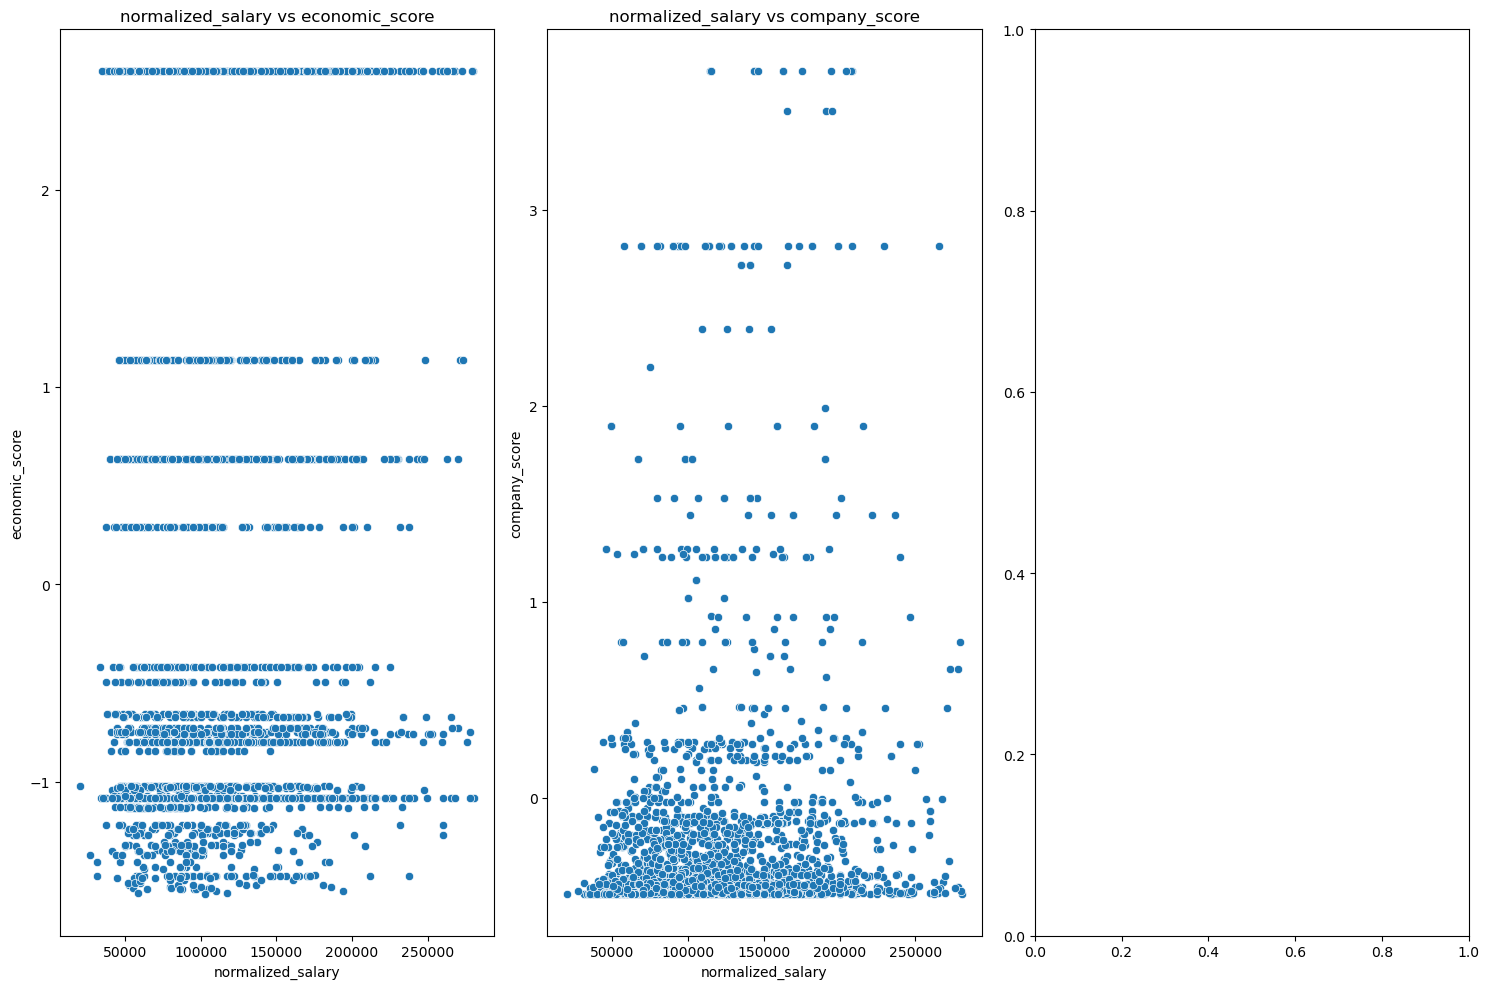

In [628]:
plot_scatter_plots(reg_df,'normalized_salary',['economic_score', 
                   'company_score'])

## LR PAR2: data spliting and first raw LR
### LASSO
### LAMBDA
### ALPHA 

In [632]:
reg_df.shape

(3002, 16)

In [634]:
# objective 1: predict normalized_salary using numerical variables and 1 dummy


#define IVs and DV

X=reg_df.drop('normalized_salary',axis=1)
y=reg_df['normalized_salary']

In [636]:
# convert categorical varibles into dummy varibles

X = pd.get_dummies(X, drop_first=True)
X.head()

,programming_languages_score,day_posting,analysis_statistics_score,machine_learning_score,data_visualization_score,cloud_platform_score,database_score,big_data_score,views,company_size,moving_score,economic_score,company_score,"degree_level_bachelor, postgraduate",degree_level_postgraduate,job_classification_Engineering,job_classification_Other
0,-0.452481,-0.25961,-1.076348,-0.159101,-0.303886,0.944862,-0.558888,-0.179187,-0.215448,-1.633884e+00,1.906802,-1.082284,-0.492001,False,False,True,False
1,-0.452481,-0.25961,-1.076348,-0.159101,-0.303886,0.944862,0.554892,-0.179187,-0.228575,-1.633884e+00,-0.665311,2.603114,-0.491520,False,False,True,False
3,-0.452481,-0.25961,-0.146959,-0.159101,-0.303886,0.944862,0.554892,-0.179187,0.467181,-2.540989e-16,1.906802,-1.082284,-0.492896,False,False,False,True
5,-0.452481,-0.25961,-0.146959,-0.159101,-0.303886,-0.643614,-0.558888,-0.179187,-0.254830,-2.540989e-16,-0.431924,-1.020576,-0.493055,False,False,True,False
6,-0.452481,-0.25961,-0.146959,-0.159101,-0.303886,0.944862,-0.558888,-0.179187,-0.294213,-2.136323e+00,-0.586909,-0.798467,-0.492790,False,False,False,False


In [638]:
# standardization
x_scaled=preprocessing.scale(X)

In [640]:
# Train-test split
#80% for training, 20% for testing

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [642]:
#lasso to identity important predeictors

In [644]:
# Create the Lasso model with an alpha value (regularization strength)
lasso_model = Lasso(alpha=0.1)  # You can adjust alpha

# Train the model on the training data
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.1)

In [646]:
# Make predictions on the testing data
y_pred = lasso_model.predict(X_test)

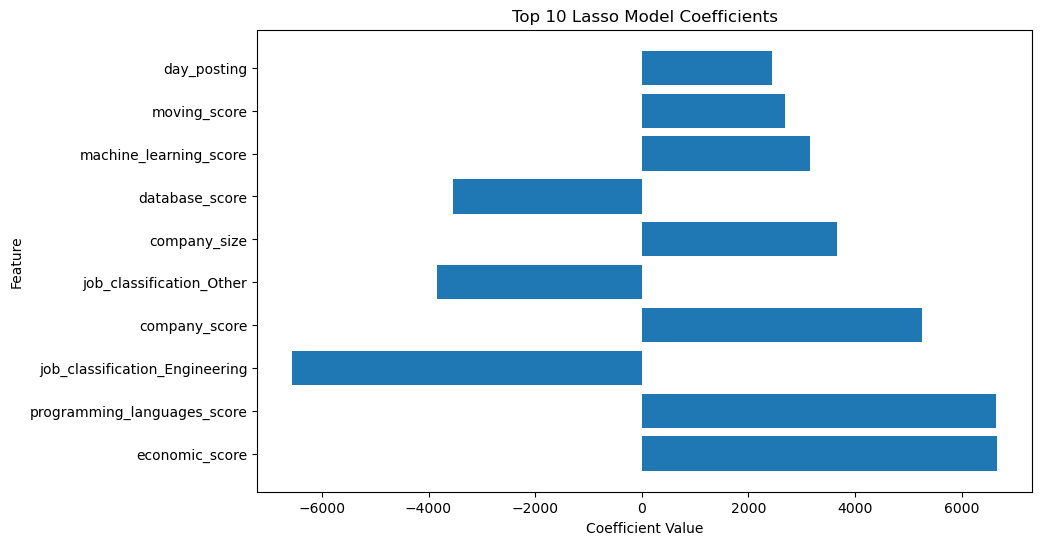

In [648]:
# Get the Lasso coefficients
coefficients = lasso_model.coef_

# Create a DataFrame for visualization
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Sort coefficients by magnitude for better visualization
top_10_coef = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)[:10]

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(top_10_coef['Feature'], top_10_coef['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Lasso Model Coefficients')
plt.show()

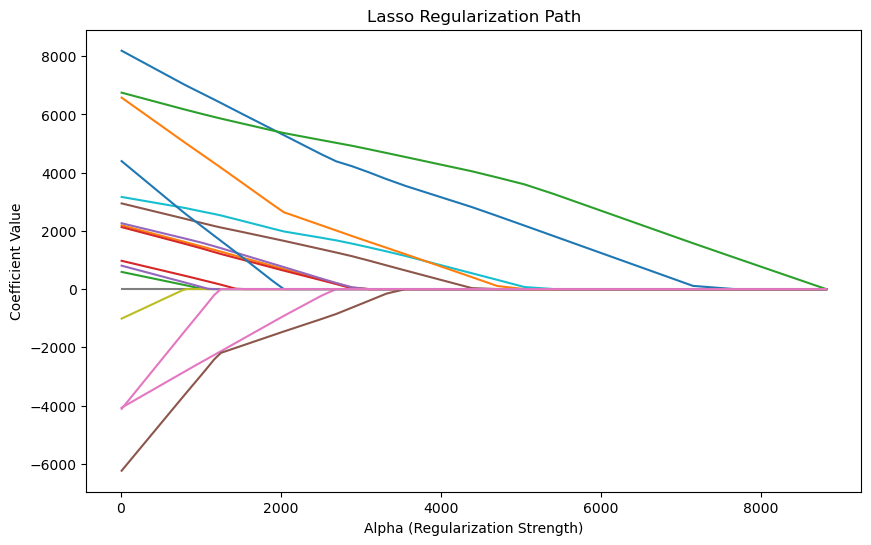

In [650]:
# Calculate the regularization path
alphas, coefs, _ = lasso_path(X_train, y_train)

# Plot the regularization path
plt.figure(figsize=(10, 6))
plt.plot(alphas, coefs.T)
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Regularization Path')
plt.show()

In [652]:
# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Print the MSE
print(np.sqrt(mse))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the RMSE
print(np.sqrt(rmse))

43497.44706153545
208.56041585482


## LR PART 3: Model with top 10 predictors

In [655]:
X.columns

Index(['programming_languages_score', 'day_posting',
       'analysis_statistics_score', 'machine_learning_score',
       'data_visualization_score', 'cloud_platform_score', 'database_score',
       'big_data_score', 'views', 'company_size', 'moving_score',
       'economic_score', 'company_score',
       'degree_level_bachelor, postgraduate', 'degree_level_postgraduate',
       'job_classification_Engineering', 'job_classification_Other'],
      dtype='object')

In [657]:
X_2=X[['programming_languages_score', 'day_posting', 'machine_learning_score',
    'database_score','company_size', 'moving_score',
    'economic_score', 'company_score',
    'job_classification_Engineering', 'job_classification_Other']]

In [659]:
y.shape

(3002,)

In [663]:
# standardization
x_scaled2=preprocessing.scale(X_2)
y_2=y

In [683]:
# Train-test split
#80% for training, 20% for testing

X_train2, X_test2, y_train2, y_test2 = train_test_split(x_scaled2, y_2, test_size=0.2, random_state=42)

In [685]:
# Step 4: Fit a baseline Linear Regression model
lr = LinearRegression()
lr.fit(X_train2, y_train2)

# Step 5: Predict on the test set
y_pred2 = lr.predict(X_test2)

# Step 6: Evaluate the baseline model
r2 = r2_score(y_test2, y_pred2)
mae = mean_absolute_error(y_test2, y_pred2)
mse = mean_squared_error(y_test2, y_pred2)

print(f"Baseline Model Performance:")
print(f"R²: {r2:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

Baseline Model Performance:
R²: 0.069
Mean Absolute Error (MAE): 34806.37
Mean Squared Error (MSE): 1931092271.57


In [669]:
coefs=lr.coef_
coefs

array([ 7087.42016337,  2641.2890416 ,  3270.00843733, -3573.16583545,
        3602.63978695,  2830.3633366 ,  6722.87228716,  5569.27441804,
       -6452.89111646, -3715.19674966])

In [687]:
from sklearn.linear_model import LassoCV, LassoLarsCV
# Lasso regression with 10-fold cross-validation
lasso = LassoLarsCV(cv=10).fit(X_train2, y_train2)
lasso


LassoLarsCV(cv=10)

In [689]:
# Predict X_test
Y_lasso = lasso.predict(X_test2)
Y_lasso
MSE_lasso= mean_squared_error(y_test2, Y_lasso)
print(f'Mean Squared Error: {MSE_lasso}')

Mean Squared Error: 1931092271.5662453


In [691]:
# Get the thetas
theta = pd.Series(lasso.coef_, index=X_2.columns)

# Sort by the absolute value of the coefficients(non-zero) and select the top two predictors
top_five_predictors = theta[theta != 0].abs().sort_values(ascending=False).head(5)

print("Top 5 Predictors after Lasso analysis:")
print(top_five_predictors)

Top 5 Predictors after Lasso analysis:
programming_languages_score       7087.420163
economic_score                    6722.872287
job_classification_Engineering    6452.891116
company_score                     5569.274418
job_classification_Other          3715.196750
dtype: float64


In [693]:
best_lambda = lasso.alpha_  
print(f'Best Lambda Value: {best_lambda}')

Best Lambda Value: 0.0


In [695]:
m_log_alphas_lars = -np.log10(lasso.alphas_)
print(m_log_alphas_lars)  # alpha or lambda, amount of regularization

[-3.8892778  -3.78038857 -3.75689751 -3.75581747 -3.58350909 -3.56994443
 -3.50824833 -3.39049237 -3.11666278 -3.03247561         inf]


/var/folders/fc/6wrgw2ln79dfcn7bb8qjd8v40000gn/T/ipykernel_49533/3880881926.py:1: RuntimeWarning:

divide by zero encountered in log10



In [697]:
theta= lasso.coef_path_.T # coefficients over different regularization
theta

array([[    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,  1623.34967748,
            0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ,
          236.03939837,     0.        ,     0.        ,  1836.64755333,
            0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ,
          246.29118125,     0.        ,    13.72266988,  1845.93531347,
            0.        ,     0.        ],
       [ 1818.68010764,     0.        ,     0.        ,     0.        ,
         1577.25381446,     0.        ,  1811.70556009,  3125.09730666,
            0.        ,     0.        ],
       [ 1921.89979995,     0.        ,    97.70259467,     0.        ,
   

In [699]:
# Find the index of the closest lambda in the alphas array
lambda_index = np.argmin(np.abs(lasso.alphas_ - best_lambda))

# Get the coefficients at that index
theta_values = lasso.coef_path_.T[lambda_index]

# Display the theta values
print("Theta values at lambda =", best_lambda)
for i, coef in enumerate(theta_values):
    print(f"Predictor {i}: {coef}")

Theta values at lambda = 0.0
Predictor 0: 7087.420163365543
Predictor 1: 2641.289041599997
Predictor 2: 3270.008437327925
Predictor 3: -3573.1658354463316
Predictor 4: 3602.6397869486
Predictor 5: 2830.3633365955643
Predictor 6: 6722.872287163927
Predictor 7: 5569.274418037627
Predictor 8: -6452.891116459515
Predictor 9: -3715.1967496593106


/var/folders/fc/6wrgw2ln79dfcn7bb8qjd8v40000gn/T/ipykernel_49533/203111257.py:4: RuntimeWarning:

divide by zero encountered in log10



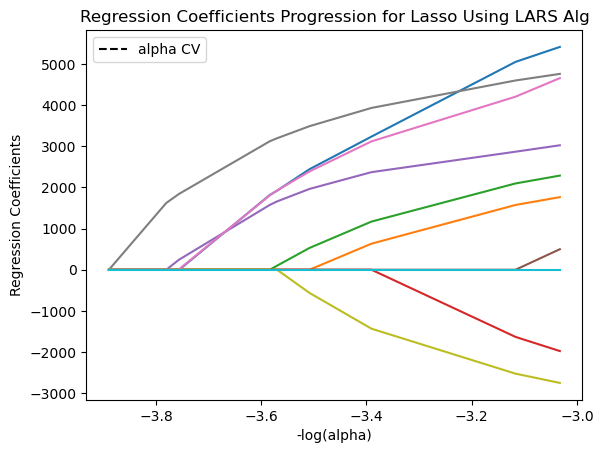

In [701]:
# plot coefficient progression lasso lars
ax = plt.gca()
plt.plot(m_log_alphas_lars, lasso.coef_path_.T)
plt.axvline(-np.log10(lasso.alpha_), linestyle='--', color='k', label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.legend()
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Using LARS Alg')
plt.show()

In [703]:
from sklearn.linear_model import Lasso
for alp in np.arange(0.0000001, 1.1, 0.1):
    clf = Lasso(alpha = alp)    # = 
    clf.fit(X_2, y)
    print(np.round(alp, 3), np.round(clf.coef_, 3), np.round(clf.intercept_, 3))

0.0 [ 11396.467  17616.485  10208.174  -7155.66    3754.733   3481.41
   4701.211   8657.665 -11780.259  -8878.731] 132190.329
0.1 [ 11396.119  17609.988  10207.478  -7155.307   3754.798   3481.193
   4701.107   8657.49  -11778.472  -8876.526] 132186.997
0.2 [ 11395.771  17603.491  10206.782  -7154.955   3754.864   3480.977
   4701.003   8657.315 -11776.685  -8874.322] 132183.665
0.3 [ 11395.423  17596.995  10206.085  -7154.604   3754.93    3480.76
   4700.899   8657.14  -11774.891  -8872.111] 132180.326
0.4 [ 11395.076  17590.499  10205.387  -7154.254   3754.997   3480.543
   4700.795   8656.965 -11773.082  -8869.888] 132176.975
0.5 [ 11394.728  17584.001  10204.691  -7153.901   3755.062   3480.327
   4700.691   8656.79  -11771.304  -8867.689] 132173.65
0.6 [ 11394.379  17577.504  10203.996  -7153.547   3755.127   3480.11
   4700.587   8656.615 -11769.525  -8865.491] 132170.325
0.7 [ 11394.031  17571.007  10203.301  -7153.193   3755.193   3479.893
   4700.483   8656.44  -11767.746  -8

0.0 1931092272.0
0.0 1931092272.0
0.0 1931092272.0
0.0 1931092272.0
0.0 1931092272.0
0.0 1931092272.0
0.0 1931092272.0
0.0 1931092272.0
0.0 1931092272.0
0.0 1931092272.0
0.0 1931092272.0
0.01 1931092272.0
0.01 1931092272.0
0.01 1931092273.0
0.02 1931092273.0
0.03 1931092274.0
0.04 1931092274.0
0.06 1931092278.0
0.09 1931092278.0
0.13 1931092275.0
0.18 1931092287.0
0.27 1931092284.0
0.39 1931092309.0
0.57 1931092307.0
0.83 1931092365.0
1.21 1931092373.0
1.76 1931092512.0
2.56 1931092573.0
3.73 1931092624.0
5.43 1931093231.0
7.91 1931093690.0
11.51 1931095611.0
16.77 1931098037.0
24.42 1931104955.0
35.56 1931118592.0
51.79 1931146004.0
75.43 1931201945.0
109.85 1931317389.0
159.99 1931557573.0
233.0 1932060198.0
339.32 1933115020.0
494.17 1935341018.0
719.69 1940040916.0
1048.11 1949977289.0
1526.42 1962099760.0
2223.0 1978544774.0
3237.46 2000654046.0
4714.87 2034539978.0
6866.49 2070863497.0
10000.0 2078689668.0


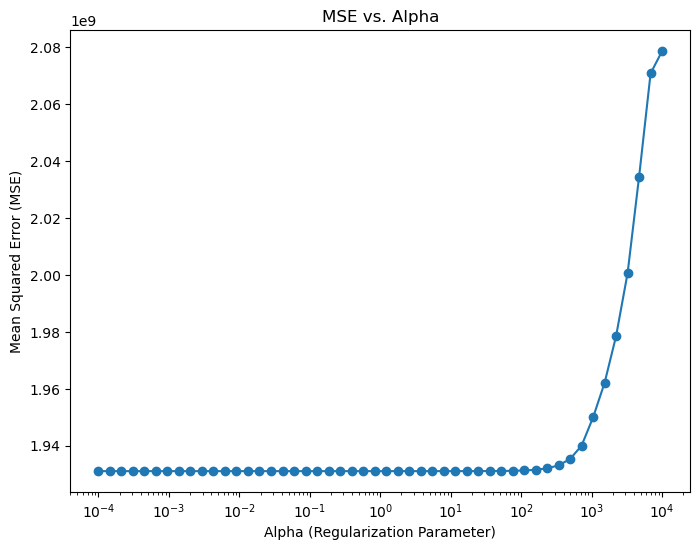

In [705]:
alphas = np.logspace(-4, 4, 50)  # 50 values from 10^-4 to 10^4
mse_scores = []

for alpha in alphas:
    clf = Lasso(alpha=alpha)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    print(np.round(alpha,2), np.round(mse))
plt.figure(figsize=(8, 6))
plt.plot(alphas, mse_scores, marker='o')
plt.xscale('log')  # Logarithmic scale for alpha
plt.xlabel('Alpha (Regularization Parameter)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Alpha')
plt.show()

In [707]:
# Step 3: K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation with the best alpha
lasso_cv_scores = cross_val_score(Lasso(alpha=1048), x_scaled, y, cv=kf, scoring='r2')

print("K-Fold Cross-Validation Results (R²):")
print(f"Mean R²: {np.mean(lasso_cv_scores):.3f}, Std: {np.std(lasso_cv_scores):.3f}")

K-Fold Cross-Validation Results (R²):
Mean R²: 0.071, Std: 0.009


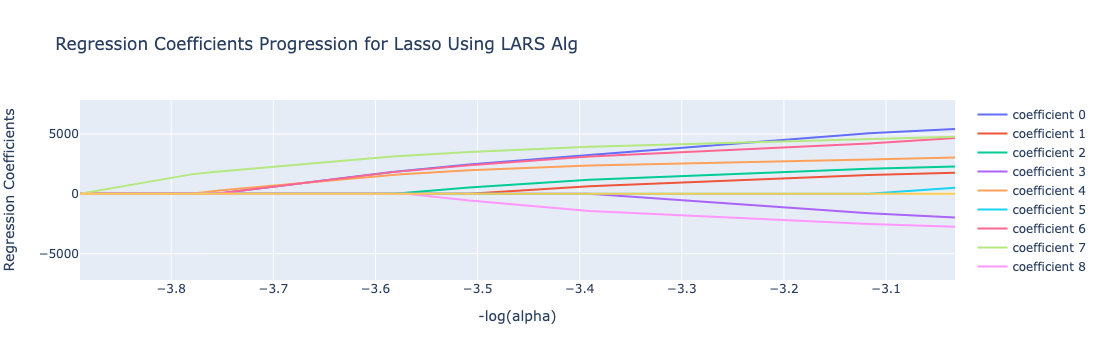

In [709]:
import plotly.graph_objects as go

# plot coefficient in a interactive graph
fig = go.Figure()
for i in range((lasso.coef_path_.shape[0])):
  fig.add_trace(go.Scatter(x=m_log_alphas_lars, y=lasso.coef_path_.T[:, i], name='coefficient '+str(i), mode='lines'))
fig.update_layout(xaxis_title="-log(alpha)", yaxis_title="Regression Coefficients", title="Regression Coefficients Progression for Lasso Using LARS Alg")
fig.show()

## 3 LR with 3 predictors: 7,4,6,0

In [712]:
X_3

,programming_languages_score,company_size,economic_score,company_score
0,-0.452481,-1.633884e+00,-1.082284,-0.492001
1,-0.452481,-1.633884e+00,2.603114,-0.491520
3,-0.452481,-2.540989e-16,-1.082284,-0.492896
5,-0.452481,-2.540989e-16,-1.020576,-0.493055
6,-0.452481,-2.136323e+00,-0.798467,-0.492790
...,...,...,...,...
3896,-0.452481,-1.131445e+00,0.636575,-0.489935
3897,-0.452481,8.783103e-01,-0.419070,-0.242403
3898,1.765587,8.783103e-01,-0.729143,-0.242403
3899,2.874621,-1.131445e+00,2.603114,-0.491431


In [714]:
X_3=reg_df[['programming_languages_score','company_size','economic_score','company_score']]
X_3.shape

(3002, 4)

In [716]:
x_scaled_3=preprocessing.scale(X_3)

In [718]:
reg_df['over10k']=(reg_df['normalized_salary'] > 85000).astype(int)

In [720]:
y_3=reg_df['over10k']

In [722]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(x_scaled_3, y_3, test_size=0.5)

In [724]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, lasso_path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, roc_curve, auc

In [726]:
tree_classifier = DecisionTreeClassifier(random_state=42)  # You can adjust hyperparameters
tree_classifier.fit(X_train3, y_train3)

DecisionTreeClassifier(random_state=42)

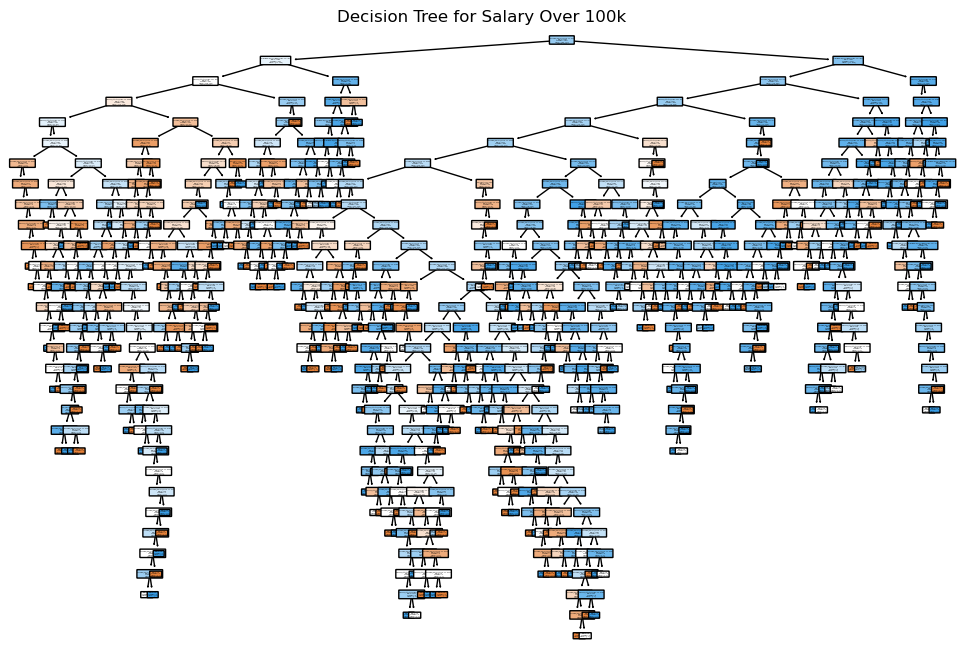

In [728]:
plt.figure(figsize=(12, 8))
plot_tree(tree_classifier, feature_names=X.columns, filled=True, rounded=True, class_names=['<=100k', '>100k'])
plt.title("Decision Tree for Salary Over 100k")
plt.show()

In [730]:
y_pred3 = tree_classifier.predict(X_test3)

In [732]:
print(classification_report(y_test3, y_pred3, target_names=['<=100k', '>100k']))

              precision    recall  f1-score   support

      <=100k       0.37      0.44      0.41       461
       >100k       0.73      0.67      0.70      1040

    accuracy                           0.60      1501
   macro avg       0.55      0.56      0.55      1501
weighted avg       0.62      0.60      0.61      1501



In [734]:
y_probs = tree_classifier.predict_proba(X_test3)

In [736]:
# For class '<=100k' (class 0)
fpr_class0, tpr_class0, thresholds_class0 = roc_curve(y_test3, y_probs[:, 0], pos_label=0)
roc_auc_class0 = auc(fpr_class0, tpr_class0)

# For class '>100k' (class 1)
fpr_class1, tpr_class1, thresholds_class1 = roc_curve(y_test3, y_probs[:, 1], pos_label=1)
roc_auc_class1 = auc(fpr_class1, tpr_class1)

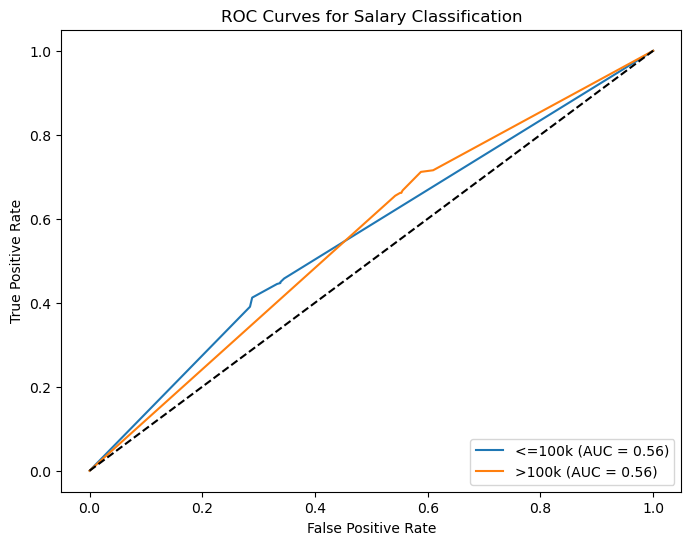

In [738]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_class0, tpr_class0, label=f'<=100k (AUC = {roc_auc_class0:.2f})')
plt.plot(fpr_class1, tpr_class1, label=f'>100k (AUC = {roc_auc_class1:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Salary Classification')
plt.legend(loc='lower right')
plt.show()

In [745]:
# Assuming 'node_id' is the ID of the desired node
node_id = 0  # Example: Starting at the root node

feature_indices = []
while node_id != -1:  # -1 indicates a leaf node
    feature_indices.append(tree_classifier.tree_.feature[node_id])
    node_id = tree_classifier.tree_.children_left[node_id]  # Follow the left branch

# Get feature names from indices
feature_names = X_3.columns[feature_indices]

# Count occurrences of each feature to determine importance
feature_importance_branch = pd.Series(feature_names).value_counts()

print("Top Predictors in Branch:", feature_importance_branch)

Top Predictors in Branch: economic_score                 4
company_score                  1
programming_languages_score    1
Name: count, dtype: int64


In [751]:
def get_top_predictors_in_branch(tree_classifier, X_3, node_id, branch_depth=3):
    """
    Gets the top predictors within a branch of a decision tree.

    Args:
        tree_classifier: The trained DecisionTreeClassifier object.
        X: The DataFrame containing the features.
        node_id: The ID of the starting node for the branch.
        branch_depth: The depth of the branch to analyze.

    Returns:
        A pandas Series containing the feature importance within the branch.
    """

    feature_indices = []
    current_depth = 0

    def traverse_branch(node_id, current_depth):
        if current_depth < branch_depth and node_id != -1:
            feature_indices.append(tree_classifier.tree_.feature[node_id])
            traverse_branch(tree_classifier.tree_.children_left[node_id], current_depth + 1)  # Left branch
            traverse_branch(tree_classifier.tree_.children_right[node_id], current_depth + 1)  # Right branch

    traverse_branch(node_id, current_depth)

    feature_names = X_3.columns[feature_indices]
    feature_importance_branch = pd.Series(feature_names).value_counts()

    return feature_importance_branch

# Analyze the first 3 branches (starting at the root node)
top_predictors_branch1 = get_top_predictors_in_branch(tree_classifier, X_3, node_id=0)
print("Top Predictors in Branch 1:", top_predictors_branch1)

Top Predictors in Branch 1: company_score                  3
programming_languages_score    2
economic_score                 2
Name: count, dtype: int64
